<a href="https://colab.research.google.com/github/PravCoder/FeedForwardNeuralNetwork_FromScratch_NoNumpy_PurePython/blob/master/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

# MANUAL BACKPROPAGATION EXAMPLE
class Value:
    # data-number-value, (previous,value,objects), operation-type
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children) #  stores unquie previous-value-objs from children-tuple
        self._op = _op
        self._backward = lambda: None # init to empty function
        self.label = label
        self.grad = 0   # ***derivative of L respect to self node***

    # ADDITION
    def __add__(self, other):  # underscore methods override primitive operations +,-,*,/ when doing these computations with Value-objs
      other = other if isinstance(other, Value) else Value(other) # if other is primative integer convert it to value
      out = Value(self.data + other.data, (self, other), "+") # output is new Value-obj with addition of data and passing in self-Value-obj and other-Value-obj as children of output

      def _backward():
        self.grad += 1.0 * out.grad  # [local-grad * global-grad] chain-rule, global-grad = derivative of final output of expression respect to out
        other.grad += 1.0 * out.grad # output-grad is basically being copied into self-grad dand other-grad

      out._backward = _backward
      return out


    # MULTIPLY
    def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other) # if other is primative integer convert it to value
      out = Value(self.data * other.data, (self, other), "*")

      def _backward():
        self.grad += other.data * out.grad # [local-grad * global-grad] chain-rule, local-grad = thing that is multiplying input it is constant derivative rule, f(x) =a*x f'(x)=a
        other.grad += self.data * out.grad

      out._backward = _backward
      return out

    # POWER
    def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,), f'**{other}')

      def _backward():
        self.grad += (other * self.data**(other-1)) * out.grad # [local-grad * global-grad] = ax^(a-1) power rule * output expression gradient respect to loss

      out._backward = _backward
      return out

    # E^X
    def exp(self):
      x = self.data # input
      out = Value(math.exp(x), (self,), "exp")

      def _backward():
        self.grad += out.data * out.grad # [local-grad * global-grad] chain-rule, local-grad = e^x, global-grad = computation equation gradient e^x

      out._backward = _backward
      return out

    # TANH
    def tanh(self):    # computes tanH activation given self.data as input
      x = self.data
      t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      out = Value(t, (self,), "tanh")

      def _backward():
        self.grad += (1-t**2) * out.grad # [local-grad * global-grad], local-grad is derivative of tanh-activation

      out._backward = _backward
      return out

    def __neg__(self): # -self, for subtraction
        return self * -1
    def __radd__(self, other): # other + self
        return self + other
    def __sub__(self, other): # self - other
        return self + (-other)
    def __rsub__(self, other): # other - self
        return other + (-self)
    def __rmul__(self, other): # other * self
        return self * other
    def __truediv__(self, other): # self / other
        return self * other**-1
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def backward(self):
      topo = []
      visited = set()  # stors unqiue visited-nodes

      def build_topo(v):    # given root node-o
        if v not in visited:    # 3: if given-node ha snot been visited, mark is as visited
          visited.add(v)
          for child in v._prev:   # 1: iterate through all the children-ndoes of givne-node
            build_topo(child)     # 2: recursivly call function on all children-nodes
          topo.append(v)          # 3: after iterating chldren add given-root-node to topological-list
      build_topo(self)   # call function by first passing in o-root-node

      self.grad = 1.0
      for node in reversed(topo):   # for every node in reversed topo-list call backward on it
        node._backward()

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e =a*b; e.label="e"
d = e+c; d.label="d"
f = Value(-2.0, label="f")
L = d*f; L.label="L"

# print(d._prev) # a*b=-6, c=10, are previous computations of d-Value-obj
# print(d)  # finial output-Value-obj
print(L)
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

L.grad = 1.0


Value(data=-8.0, grad=0)


In [3]:
# L = d * f
f.grad = d.data # setting dL/df = d gradient, derivative of L respect to f is just d
d.grad = f.data # setting dL/dd = f gradient                                                                                                                                                                 , derivative of L respect to d is just f

# local stuff
def lol():
  h = 0.0001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e =a*b; e.label="e"
  d = e+c; d.label="d"
  f = Value(-2.0, label="f")
  L = d*f; L.label="L"  # setting resultant object.label
  L1 = L.data

  a = Value(2.0 + h, label="a") # bumping a by h which computes derivative of L respect to a
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e =a*b; e.label="e"
  d = e+c; d.label="d"
  f = Value(-2.0, label="f")
  L = d*f; L.label="L"
  L2 = L.data

  print("dL/db: "+str((L2-L1)/h))  # printing derviative of L respect to a

lol()

c.grad = -2.0   # setting dL/dc gradient
e.grad = -2.0   # setting dL/de gradient

a.grad = 6.0    # setting dL/da gradient
b.grad = -4.0   # setting dL/bd

dL/db: 6.000000000021544


In [16]:
"""
WANT:
dL / dc = (dL /dd) * (dd / dc) = -2.0 * 1.0 = -2.0
dL / de = (dl / dd) * (dd / de ) = -2.0 * 1.0 = -2.0
KNOW:
d = c + e
dd / dc = 1.0, from calculus constant of c is 1
dd / de = 1.0, from calculus

L = d * f
dL /dd = f = -2.0


WANT:
dL / da = (dL /de) * (de /da) = -2.0 * -3.0 = 6.0
dL / db = (dL /de) * (de /db) = -2.0 * 2.0 = -4.0
KNOW:
e = a * b
de /da = b, from calculus
de /db = a, from calculus
dL / de = -2.0


TO VERIFY THESE GRADIENT COMPUTATIONS:
add h to the variable to are deriving respect to and print that value and see if it matches manually computed value
"""

'\nWANT:\ndL / dc = (dL /dd) * (dd / dc) = -2.0 * 1.0 = -2.0\ndL / de = (dl / dd) * (dd / de ) = -2.0 * 1.0 = -2.0\nKNOW:\nd = c + e\ndd / dc = 1.0, from calculus constant of c is 1\ndd / de = 1.0, from calculus\n\nL = d * f\ndL /dd = f = -2.0\n\n\nWANT:\ndL / da = (dL /de) * (de /da) = -2.0 * -3.0 = 6.0\ndL / db = (dL /de) * (de /db) = -2.0 * 2.0 = -4.0\nKNOW:\ne = a * b\nde /da = b, from calculus\nde /db = a, from calculus\ndL / de = -2.0\n\n\nTO VERIFY THESE GRADIENT COMPUTATIONS:\nadd h to the variable to are deriving respect to and print that value and see if it matches manually computed value\n'

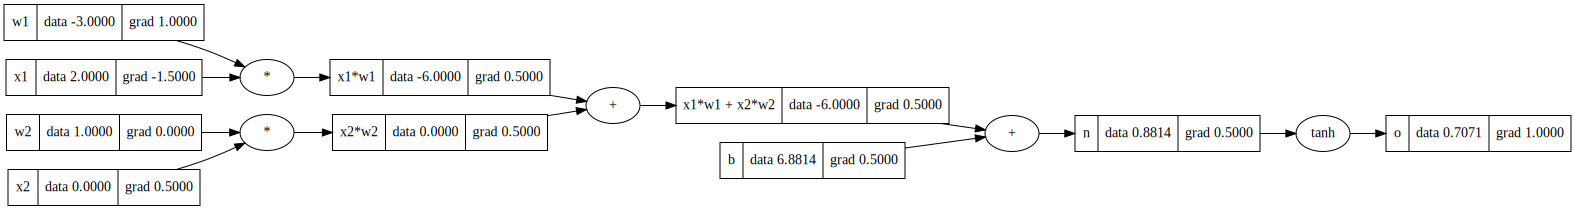

In [51]:

# BACKPROPAGATION FOR SINGUALAR NEURON:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# compute product of weights*inputs
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
# compute sum of products and weights
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
# compute z-weighted-sum by adding bias
n = x1w1x2w2 + b; n.label="n"
# compute output of neuron by applying tanH-activation on z-weighted-sum
o = n.tanh(); o.label="o"


# MANUAL BACKWARD PASS:
"""
# FIND: do/x1, do/x2, do/w1, do/w2, f(x) = a*x f'(x)=df/dx=a
# we have local nodes/equations x2*w2 and x1*w1
x2.grad = w2.data * x2w2.grad   # do/x2 = [local-grad] * [cur-grad] = dx2w2/dx2 * do/dx2w2 = w2 * do/dx2w2
w2.grad = x2.data * x2w2.grad   # do/w2 = [local-grad] * [cur-grad] = dx2w2/dw2 * do/dx2w2 = x2 * do/dx2w2
x1.grad = w1.data * x1w1.grad   # do/x1 = [local-grad] * [cur-grad] = dx1w1/dx1 * do/dx1w1 = w1 * do/x1w1
w1.grad = x1.data * x1w1.grad   # do/w1 = [local-grad] * [cur-grad] = dx1w1/dw1 * do/dx1w1 = x1 * do/x1w1
# FIND: d0/x1w1, do/dx2w2
# its a plus gate so x1w1x2w2's gradient distributes to its children, f(x)=c+x f'(x)=df/dx=1, [local-grad]*[x1w1x2w2-grad] = 1*0.5 = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5

# FIND: do/d(x1w1x2w2/z), do/db
# its a plus gate so n's gradient distributes to its children, f(x)=c+x f'(x)=df/dx=1, [local-grad]*[n-grad] = 1*0.5 = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

# FIND: do/dn
# o = tanh(n)
# derivative of tanh is 1 - tanh(n)^2
# do/dn = 1 - o^2, derivative of o respect to n is same as derivative of tanh respect to its input n
n.grad = 1 - o.data**2  # approx 0.4449

# FIND: d0/do
# derivative of output respect to output is 1, base case do/do
o.grad = 1.0
"""

# FUNCTION BACKWARD PASS:
"""
o.grad = 1.0
o._backward()
n._backward()
b._backward()  # does nothing because its leaf node
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()"""

o.backward() # calling main-backward functionon output-node


draw_dot(o)
# work your way from BOTTOM TO TOP for manual backward pass
# gradient every point represents if we want the output of the neuron to increase then the infleunce of these expressions are positive/negative contribution on the output
# Notes:
# - to call node.backward have to call backward() on everything after it
# - have to accumlate gradients with += because its multivariate case of chain rule
# TODO:
# - review backward()




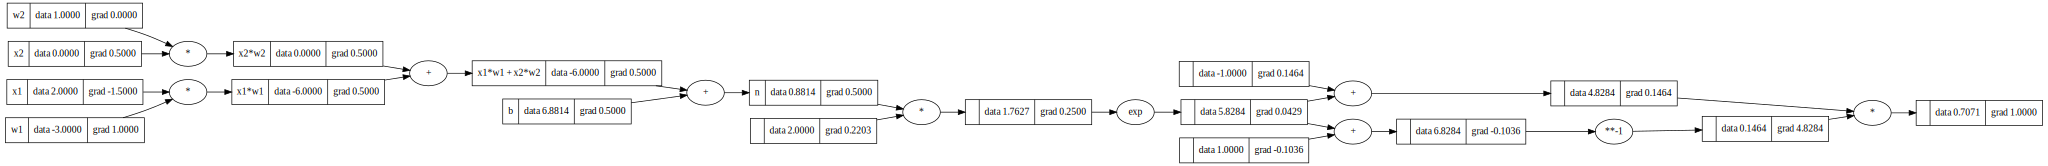

In [50]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
# compute product of weights*inputs
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
# compute sum of products and weights
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
# compute z-weighted-sum by adding bias
n = x1w1x2w2 + b; n.label="n"

# tanH using defined operations
e = (2*n).exp()   # intermediate variable, e^(2x)
o = (e - 1) / (e + 1)  # tanH forumla

o.backward()
draw_dot(o)

In [40]:
a = Value(2.0)
b = Value(4.0)
print(a - b)

Value(data=-2.0, grad=0)
